In [1]:
import random
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import datetime as dt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

In [2]:
import sklearn as skl
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from matplotlib.colors import ListedColormap
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.metrics import roc_curve,roc_auc_score, auc
from scipy import interp
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit


In [3]:
majorLocator = MultipleLocator(1)
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
n_classes = 2
mpl.rcParams['figure.figsize']=(20,10)
np.set_printoptions(threshold=np.nan)
LEARNING_RATE = 0.5

In [4]:
def readData(filename):
    dataset = []
    infile = open(filename, 'r')
    import csv
    for row in csv.reader(infile):
        dataset.append(row)
    infile.close()
    for j in range (len(dataset[0])):
        try:
            float(dataset[0][j])
        except ValueError: continue
        else:
            for i in range(len(dataset)):
                dataset[i][j] =float(dataset[i][j])
   
    return np.array(dataset)
    

In [5]:
def pca(featureMatr):
   
    pca = PCA(n_components = len(featureMatr[0])-2)
    pca.fit(featureMatr)
    print(featureMatr[:4])
    featureMatrRed = pca.transform(featureMatr)
    print(featureMatrRed[:4])

    return featureMatrRed


In [6]:
def splitData(limit, dataset):
    trainData = dataset[: limit]
    testData = dataset[limit: ]
    return trainData, testData    

In [7]:
def plotFeatures(featureMatrRed,responseMatr):
    plt.scatter(featureMatrRed[:,0],featureMatrRed[:,-1], c=responseMatr)
    plt.title(r'$train MSE$')
    plt.grid(True)
    plt.show()

In [8]:
def plotFeaturesProj(featureMatr, responseMatr):
    #featureMatrProj = preprocessing.normalize(featureMatr,norm='l2', axis = 0)
    for i in range (len(featureMatr[0])):
        if (i<len(featureMatr[0])-1):
            for j in range (i+1,len(featureMatr[0])):
                print(i," ",j)
                plt.scatter(featureMatr[:,i], featureMatr[:,j], c=responseMatr)
                plt.title(r'$train MSE$')
                plt.grid(True)
                title = ["Месяцы с последней ширки", "общее количество пожертвований","Денежная сумма", "Месяцы с первого раза"]
                plt.xlabel(title[i])
                plt.ylabel(title[j])
                plt.show()

In [9]:
def knnCV(dataset, n_neighbors,n_train, n_CV, metric):
    X,y = dataset[:,:-1], dataset[:,-1]
    tprs = []
    frp_arr = []
    tpr_arr = []
    aucs_arr = []
    aucs=0
    mean_fpr = np.linspace(0, 1, 100)
    precision_cv = 0
    accuracy_cv = 0
    recall_cv = 0
    f1_cv = 0
    cv = StratifiedShuffleSplit(n_splits=n_CV, test_size=n_train)
    classifier = KNeighborsClassifier(n_neighbors = n_neighbors, metric=metric)
    X_test = [] 
    y_test = []
    predicted = []
    
    for train, test in cv.split(X,y):
        predicted = classifier.fit(X[train], y[train]).predict(X[test])
        predicted_proba = classifier.fit(X[train], y[train]).predict_proba(X[test])

        fpr_0, tpr_0, thresholds_0 = roc_curve(y[test], predicted_proba[:,0])
        fpr_1, tpr_1, thresholds_1 = roc_curve(y[test], predicted_proba[:,1])

        tprs.append(interp(mean_fpr, fpr_1, tpr_1))
        tprs[-1][0] = 0.0
        tpr_arr.append(tpr_1)
        frp_arr.append(fpr_1)
        roc_auc = roc_auc_score(y[test], predicted_proba[:,1])

        aucs_arr.append(roc_auc)
        aucs += roc_auc
        f1_cv += f1_score(y[test], predicted)
        recall_cv += recall_score(y[test], predicted)
        precision_cv += precision_score(y[test], predicted)
        accuracy_cv += accuracy_score(y[test], predicted)

        X_test = X[test]
        y_test = y[test]
    
    return X_test, y_test,predicted, accuracy_cv/n_CV, precision_cv/n_CV, f1_cv/n_CV, recall_cv/n_CV,aucs_arr, aucs/n_CV, tprs,tpr_arr, frp_arr

In [10]:
def knn_neigh_choice(dataset,n_neig_max, n_neigh_min,n_train, n_cv):
    acc_arr = []
    rec_arr = []
    prec_arr = []
    f1_arr = []
    for n_neighbors in range (n_neigh_min, n_neig_max+1,2):
        [feature, response, predicted,acc,prec,f1,rec,aucs,tprs,fp, ad] =  knnCV(dataset,n_neighbors,n_train, n_cv)
        acc_arr.append(acc)
        rec_arr.append(rec)
        prec_arr.append(prec)
        f1_arr.append(f1)   
    x = [x for x in range (n_neigh_min, n_neig_max+1,2)]
    ax = plt.subplot()
 
    plt.plot(x,acc_arr, label = "accuracy")
    plt.plot(x,prec_arr, label = "precision")
    plt.plot(x,f1_arr, label = "f_score")
    plt.plot(x,rec_arr, label = "recall")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.grid(True)
    plt.show()   



In [11]:
def logisticCV(dataset,n_train, n_CV, C):  
    X,y = dataset[:,:-1], dataset[:,-1]
    tprs = []
    frp_arr = []
    tpr_arr = []
    aucs_arr = []
    aucs=0
    mean_fpr = np.linspace(0, 1, 100)
    precision_cv = 0
    accuracy_cv = 0
    recall_cv = 0
    f1_cv = 0
    cv = StratifiedShuffleSplit(n_splits=n_CV, test_size=n_train)
    classifier = LogisticRegression(solver = "liblinear")
    X_test = [] 
    y_test = []
    predicted = []
    
    for train, test in cv.split(X,y):
        predicted = classifier.fit(X[train], y[train]).predict(X[test])
       
        predicted_proba = classifier.fit(X[train], y[train]).predict_proba(X[test])
     
        fpr_0, tpr_0, thresholds_0 = roc_curve(y[test], predicted_proba[:,0])
        fpr_1, tpr_1, thresholds_1 = roc_curve(y[test], predicted_proba[:,1])

        tprs.append(interp(mean_fpr, fpr_1, tpr_1))
        tprs[-1][0] = 0.0
        tpr_arr.append(tpr_1)
        frp_arr.append(fpr_1)
        roc_auc = roc_auc_score(y[test], predicted_proba[:,1])
        aucs_arr.append(roc_auc)
        aucs += roc_auc
        f1_cv += f1_score(y[test], predicted)
        recall_cv += recall_score(y[test], predicted)
        
        precision_cv += precision_score(y[test], predicted)
        accuracy_cv += accuracy_score(y[test], predicted)

        X_test = X[test]
        y_test = y[test]
    
    return X_test, y_test,predicted, accuracy_cv/n_CV, precision_cv/n_CV, f1_cv/n_CV, recall_cv/n_CV,aucs_arr, aucs/n_CV, tprs,tpr_arr, frp_arr


In [12]:
def svmCV(dataset,n_train, n_CV, C, kernel, gamma):  
    X,y = dataset[:,:-1], dataset[:,-1]
    tprs = []
    frp_arr = []
    tpr_arr = []
    aucs_arr = []
    aucs=0
    mean_fpr = np.linspace(0, 1, 100)
    precision_cv = 0
    accuracy_cv = 0
    recall_cv = 0
    f1_cv = 0
    cv = StratifiedShuffleSplit(n_splits=n_CV, test_size=n_train)
    classifier = SVC(probability = True, C=C, kernel = kernel, gamma = gamma)
    X_test = [] 
    y_test = []
    predicted = []
    
    for train, test in cv.split(X,y):
        predicted = classifier.fit(X[train], y[train]).predict(X[test])
       
        predicted_proba = classifier.fit(X[train], y[train]).predict_proba(X[test])
     
        fpr_0, tpr_0, thresholds_0 = roc_curve(y[test], predicted_proba[:,0])
        fpr_1, tpr_1, thresholds_1 = roc_curve(y[test], predicted_proba[:,1])

        tprs.append(interp(mean_fpr, fpr_1, tpr_1))
        tprs[-1][0] = 0.0
        tpr_arr.append(tpr_1)
        frp_arr.append(fpr_1)
        roc_auc = roc_auc_score(y[test], predicted_proba[:,1])
        aucs_arr.append(roc_auc)
        aucs += roc_auc
        f1_cv += f1_score(y[test], predicted)
        recall_cv += recall_score(y[test], predicted)
        
        precision_cv += precision_score(y[test], predicted)
        accuracy_cv += accuracy_score(y[test], predicted)

        X_test = X[test]
        y_test = y[test]
    
    return X_test, y_test,predicted, accuracy_cv/n_CV, precision_cv/n_CV, f1_cv/n_CV, recall_cv/n_CV,aucs_arr, aucs/n_CV, tprs,tpr_arr, frp_arr


In [13]:
def plotCompare(arr):
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=None, hspace=0.7)
    ax1 = plt.subplot2grid((5, 2), (0, 0), colspan=2, rowspan = 2)
    knn = arr[0]
    ax1.scatter((knn[0])[:,0],(knn[0])[:,1], c=knn[1])
    ax1.set_title("PCA results")
    title = ["KNN_", "LOG_", "SVM_"]
    for i in range(1, len(arr)):
        X = arr[i][0]
        y = arr[i][1]
        fpr_arr = arr[i][-1]
        tpr_arr = arr[i][-2]
        tprs = arr[i][-3]   
        mean_auc = arr[i][-4]
        aucs = arr[i][-5]
        mean_fpr = np.linspace(0, 1, 100)  
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        std_auc = np.std(aucs)

        ax3 = plt.subplot2grid((5, 2), (i+1, 0), colspan=1)
        ax3.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)
        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        ax3.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')
        ax3.set_xlabel('False Positive Rate')
        ax3.set_ylabel('True Positive Rate')
        ax3.set_title(title[i-1]+'ROC')
        ax3.plot([0,1], [0,1], linestyle = '--', dashes=(5, 1))
        ax4 = plt.subplot2grid((5, 2), (i+1, 1), colspan=1)
        str = title[i-1]+"\nAccuracy %f\nPrecision %f\nRecall %f\nF_score %f\nAUC %f $\pm$ %f" %(arr[i][3],arr[i][4],arr[i][6],arr[i][5],mean_auc,std_auc)
        ax4.set_title("Q")
        ax4.text(0.1,0.2,str,fontsize=15 )
        ax4.axis("off")
    plt.show()

In [14]:
def normalize(featureMatr):
    for i in range (len(featureMatr)):
        for j in range(len(featureMatr[0])):
            featureMatr[i][j] = (featureMatr[i][j] - featureMatr[:,j].min()) / (featureMatr[:,j].max() - featureMatr[:,j].min())
    return featureMatr



[[ 0.02702703  1.          1.          1.        ]
 [ 0.          0.26666667  0.28254631  0.27835052]
 [ 0.01351351  0.34402332  0.34781006  0.35531174]
 [ 0.02702703  0.43148688  0.43476872  0.45764321]]
[[ 1.28398464 -0.23978808]
 [ 0.03239932 -0.155001  ]
 [ 0.15970402 -0.1568625 ]
 [ 0.32039623 -0.1534081 ]]


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


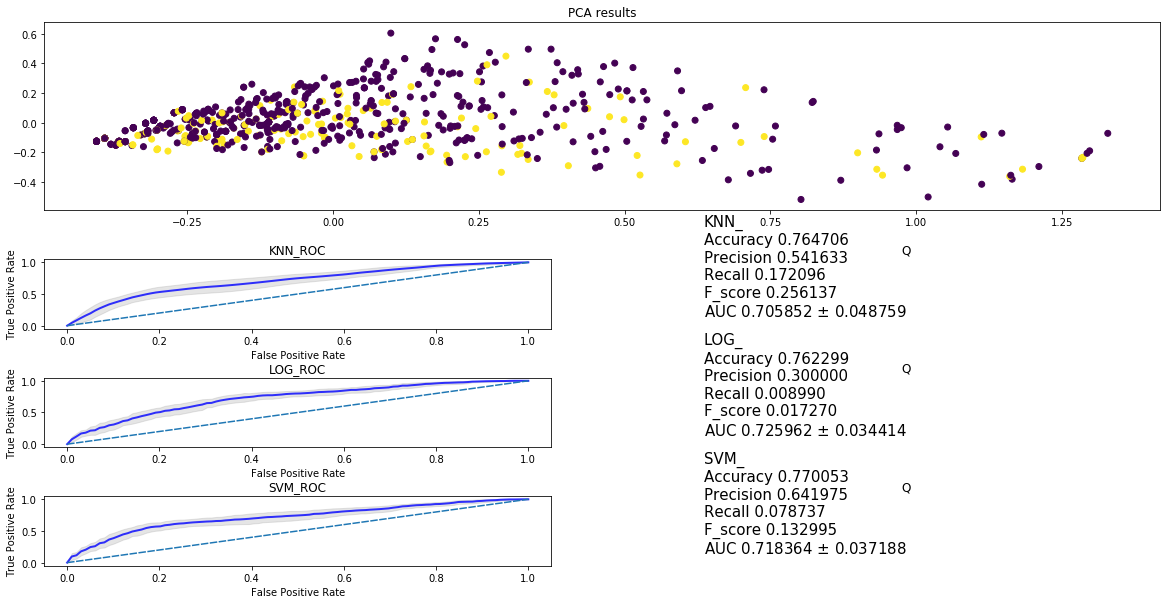

In [15]:
featureMatrRow = []
arr = readData("transfusion.txt")
featureMatrR1 = [row[:-1] for row in arr]
featureMatrR = np.array(featureMatrR1)
featureMatr = normalize(featureMatrR)
featurePCA = pca(featureMatr)
responseMatr = np.array([row[-1] for row in arr]).reshape((len(arr),1))
dataset = np.concatenate((featureMatr,responseMatr), axis=1)
datasetPCA = np.concatenate((featurePCA,responseMatr), axis=1)

arr = []
arr.append ([datasetPCA[:,:-1],datasetPCA[:,-1]])
arr.append(knnCV(dataset,25,0.25,20, "minkowski"))
arr.append(logisticCV(dataset,0.25,20, 10000))
arr.append(svmCV(dataset,0.25,20, 1000, "rbf","auto"))

plotCompare(arr)